[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>
Adapted by Claudio Sartori

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be __train_size__ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - since the target is multiclass, consider the two versions of the score functions `_macro` and `_weighted` (not for the accuracy)
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


In [2]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings



### Prepare the environment
The data file is located in `"../../data/winequality-red.csv"` on your github repository, the `target` is `quality

Prepare the data and the target in X and y. Set `ts`. Set the random state

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size'   : 10})
random_state = 19
train_size = 0.67
n_splits = 3
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

data_url = "data/winequality-red.csv"
sep = ';'
# sep = ','
target = 'quality'

Read the data into a dataframe and show the size

In [4]:
df = pd.read_csv(data_url,sep=sep)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
# optional data modification, to merge quality levels 3 and 4
### Change quality label 3 to 4 in the dataframe
display("quality value counts before:\n", df[target].value_counts().sort_index())
df.loc[df[target] == 3, target] = 4
display("quality value counts after:\n", df[target].value_counts().sort_index())

'quality value counts before:\n'

quality
4     63
5    681
6    638
7    199
8     18
Name: count, dtype: int64

'quality value counts after:\n'

quality
4     63
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Have a quick look to the data.
- use the `.head()` function to see column names and some data
- use other exploration methods if you want

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


You could also explore the dataset, as you did in the previous labs, if you want.

Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

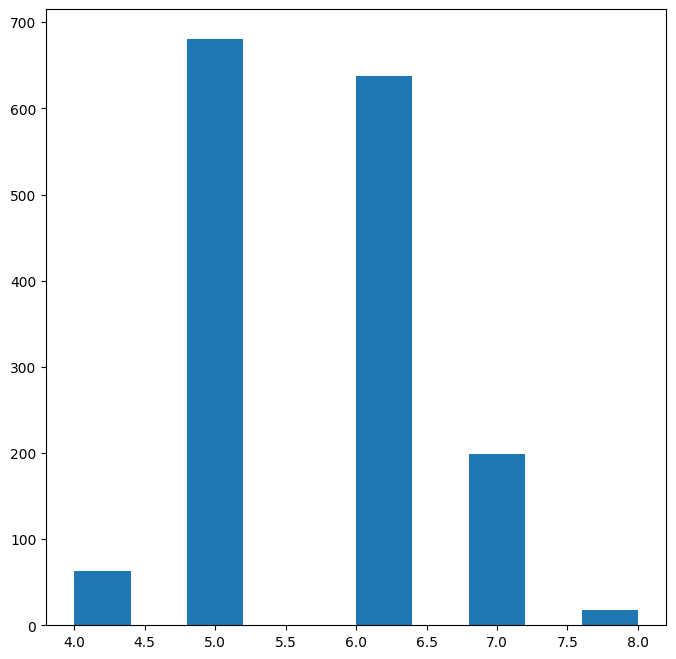

In [12]:
plt.hist(df[target])
plt.show()

#### Split the data into the __predicting values__ `X` and the __target__ `y`
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [15]:
train , test = train_test_split(df,train_size=train_size)

train_dropped = train.drop(columns = [target])
test_dropped = test.drop(columns = [target])
display(train_dropped)
display(test_dropped)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1242,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2
1276,8.5,0.40,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0
1056,8.9,0.48,0.53,4.0,0.101,3.0,10.0,0.99586,3.21,0.59,12.1
1053,8.3,0.33,0.42,2.3,0.070,9.0,20.0,0.99426,3.38,0.77,12.7
1226,7.5,0.58,0.03,4.1,0.080,27.0,46.0,0.99592,3.02,0.47,9.2
...,...,...,...,...,...,...,...,...,...,...,...
427,9.5,0.78,0.22,1.9,0.077,6.0,32.0,0.99880,3.26,0.56,10.6
482,10.6,0.36,0.59,2.2,0.152,6.0,18.0,0.99860,3.04,1.05,9.4
723,7.1,0.31,0.30,2.2,0.053,36.0,127.0,0.99650,2.94,1.62,9.5
188,7.9,0.50,0.33,2.0,0.084,15.0,143.0,0.99680,3.20,0.55,9.5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
219,7.8,0.530,0.33,2.40,0.080,24.0,144.0,0.99655,3.30,0.60,9.5
502,10.4,0.440,0.73,6.55,0.074,38.0,76.0,0.99900,3.17,0.85,12.0
1254,7.8,0.700,0.06,1.90,0.079,20.0,35.0,0.99628,3.40,0.69,10.9
257,6.6,0.695,0.00,2.10,0.075,12.0,56.0,0.99680,3.49,0.67,9.2
113,10.1,0.310,0.44,2.30,0.080,22.0,46.0,0.99880,3.32,0.67,9.7
...,...,...,...,...,...,...,...,...,...,...,...
1350,9.0,0.600,0.29,2.00,0.069,32.0,73.0,0.99654,3.34,0.57,10.0
595,8.9,0.595,0.41,7.90,0.086,30.0,109.0,0.99980,3.27,0.57,9.3
1305,7.5,0.610,0.26,1.90,0.073,24.0,88.0,0.99612,3.30,0.53,9.8
886,9.0,0.800,0.12,2.40,0.083,8.0,28.0,0.99836,3.33,0.65,10.4


### Prepare the baseline: holdout method

In [16]:
print(f"There are {train_dropped.shape[0]} in the training set")
print(f"There are {test_dropped.shape[0]} in the test set")
print(f"Each sample has  {train_dropped.shape[1]} features ")


There are 1071 in the training set
There are 528 in the test set
Each sample has  11 features 


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`
- Fit the estimator on the train data and target

In [20]:
model = tree.DecisionTreeClassifier(random_state = random_state)
model.fit(train_dropped,y=train[target])

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,19
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Predict the target for the training set and show the accuracy comparing the prediction with the ground truth for the trainin set

In [39]:
acc = model.score(train_dropped,train[target])
acc= format(acc*100,".2f")
print(f"the accuracy for model is {acc}%")

the accuracy for model is 100.00%


Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [40]:
fitted_max_depth = model.tree_.max_depth
parameter_values = range(1,fitted_max_depth)
acc = model.score(test_dropped,test[target])
acc= format(acc*100,".2f")
print(f"the accuracy for model is {acc}%")
print(f"The maximum depth of the tree fitted on X_train is {fitted_max_depth}")

the accuracy for model is 59.66%
The maximum depth of the tree fitted on X_train is 18


Prepare the decision tree parameters and the scores 

In [41]:
# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,fitted_max_depth+1)] # try all depths from 1 to the unconstrained fitted one        
                   # the *       
                , 'criterion' : ['entropy', 'gini'] #
                , 'class_weight' : [None, 'balanced']}]

scores = ['precision_macro'
        , 'precision_weighted'
        , 'recall_macro'
        , 'recall_weighted'
        , 'f1_macro'
        , 'f1_weighted'
        , 'accuracy']

### Loop on scores
- initialize the splitter for the grid search `StratifiedKfold`, specifying the number of splits, the random_state and `shuffle=True`
- iterate varying the score function
    - fit the estimator using the training data
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best score
    - predict the target for the test set using the `.predict` method
    - print the `classification_report`
    - generate the `confusion_matrix`
    - display the confusion matrix with `ConfusionMatrixDisplay`


Observation: the paired plots can be obtained with the `plt.subplots` command, but standard plots one by one are perfectly acceptable

# Tuning hyper-parameters for 'precision_macro'
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6}
Best score 37.445%
              precision    recall  f1-score   support

           4       0.14      0.11      0.12        19
           5       0.64      0.72      0.68       222
           6       0.52      0.58      0.55       205
           7       0.62      0.27      0.38        77
           8       0.00      0.00      0.00         5

    accuracy                           0.57       528
   macro avg       0.38      0.34      0.34       528
weighted avg       0.56      0.57      0.56       528

# Tuning hyper-parameters for 'precision_weighted'
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 9}
Best score 55.253%
              precision    recall  f1-score   support

           4       0.13      0.11      0.12        19
           5       0.67      0.77      0.71       222
           6       0.60      0.58      0.59       205
           7       0.56      0.

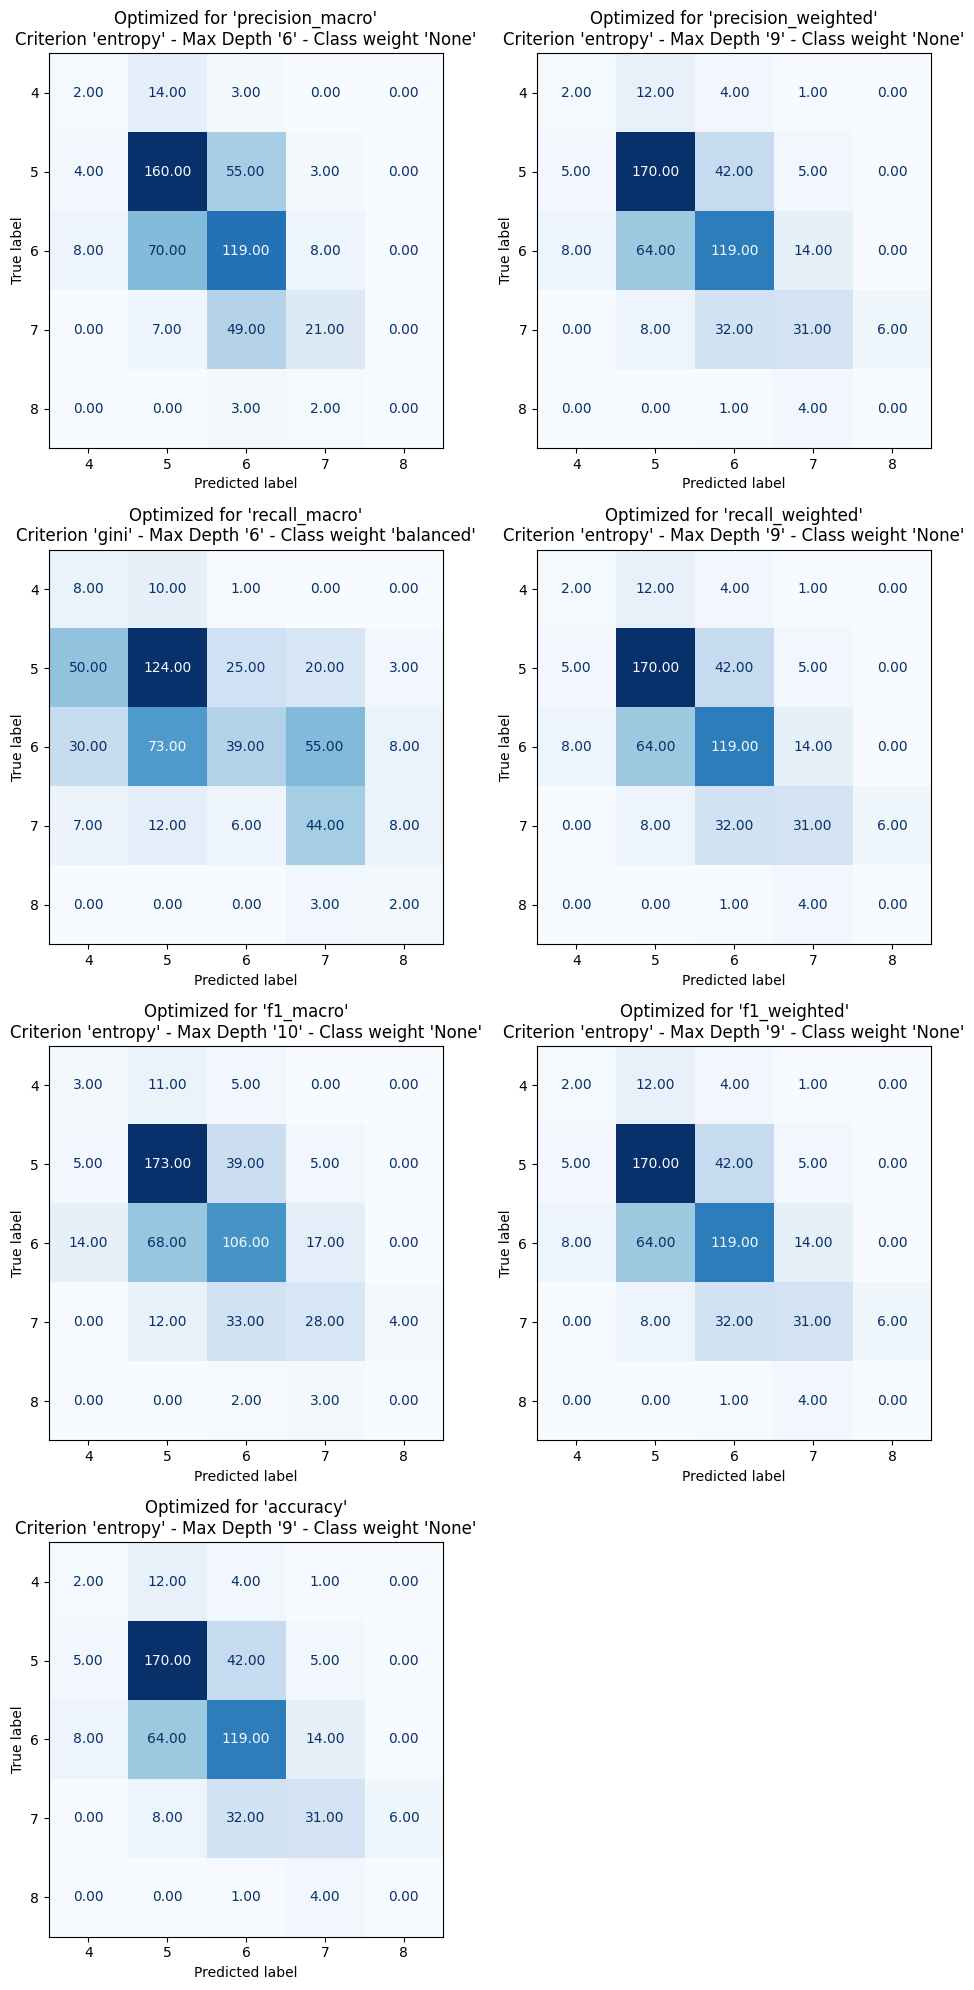

In [42]:

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, random_state=random_state
                      , shuffle=True # shuffle to ensure randomness, otherwise
                                     # the splits are generated in the order of the input data  
                      )

# Prepare subplot grid: 2 columns, as many rows as needed
n_scores = len(scores)
n_cols = 2
n_rows = int(np.ceil(n_scores / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
axes = axes.flatten()  # Flatten to index easily

for idx, score in enumerate(scores):
    print('=' * 40)
    print(f"# Tuning hyper-parameters for '{score}'")

    clf = GridSearchCV(
        estimator=model, #
        param_grid=tuned_param_dt,
        scoring=score,
        return_train_score=False,
        cv=skf
    )

    clf.fit(train_dropped, train[target])
    best_params = clf.best_params_ # get the best parameters, it is a dictionary
    print(best_params)
    print(f"Best score {clf.best_score_ * 100:6.3f}%")

    y_p = clf.best_estimator_.predict(test_dropped)
    print(classification_report(test[target], y_p, zero_division=0))

    # Compute confusion matrix (normalized)
    cm = confusion_matrix(test[target], y_p
                        #   , labels=clf.best_estimator_.classes_ 
                        #   , normalize='true' # uncomment this line to have normalized confusion matrix
                          )

    # Display with numeric values
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=axes[idx], colorbar=False, cmap='Blues', values_format='.2f')

    axes[idx].set_title(
        f"Optimized for '{score}'\n"
        f"Criterion '{best_params.get('criterion', 'N/A')}' - " # the 'N/A' is just a fallback
        f"Max Depth '{best_params.get('max_depth', 'N/A')}' - "
        f"Class weight '{best_params.get('class_weight', 'N/A')}'"
    )

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
## The following code block is ignored in the notebook, it is just to show how to collect all classification reports in a DataFrame
# from sklearn.metrics import classification_report

# # Collect classification reports for each score in a list of dicts
# reports = []
# for score in scores:
#     clf = GridSearchCV(
#         estimator=estimator,
#         param_grid=tuned_param_dt,
#         scoring=score,
#         return_train_score=False,
#         cv=skf
#     )
#     clf.fit(X_train, y_train)
#     y_pred = clf.best_estimator_.predict(X_test)
#     report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     report_dict['score_metric'] = score
#     reports.append(report_dict)

# # Flatten the reports for each class and metric
# flat_reports = []
# for rep in reports:
#     score_metric = rep.pop('score_metric')
#     for label, metrics in rep.items():
#         if isinstance(metrics, dict):
#             row = {'score_metric': score_metric, 'label': label}
#             row.update(metrics)
#             flat_reports.append(row)

# # Create DataFrame
# report_df = pd.DataFrame(flat_reports)
# report_df

In [15]:
# Print versions of key packages
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn as sns

print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")


Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
pandas version: 2.2.3
NumPy version: 1.26.4
scikit-learn version: 1.6.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
